<a href="https://colab.research.google.com/github/MikhailKuklin/time-series-analysis-forecasting/blob/main/notebooks/ts_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [109]:
# libraries

import numpy as np
import pandas as pd
from matplotlib import dates
from pylab import rcParams
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error,mean_absolute_error
from statsmodels.tsa.statespace.tools import diff
%matplotlib inline

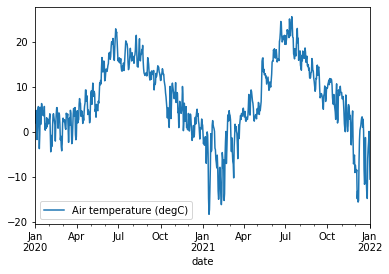

In [110]:
# download data and parse date to datetime

df = pd.read_csv('espoo_2020_2022.csv',
                 parse_dates= {"date" : ["Year","m","d"]})

df.dropna(axis=0,inplace=True)

df = df.groupby(['date']).mean()

df.index.freq = "D"

df.plot();

In [111]:
# rename column

#df['Temperature (C)'] = df['Air temperature (degC)']
#df.drop(['Air temperature (degC)'],axis=1, inplace=True)

In [112]:
# create training and test sets

df_train = df.iloc[:586]
df_test = df.iloc[585:]

In [113]:
# fit model

fitted_model = ExponentialSmoothing(df_train['Air temperature (degC)'],trend='add',seasonal='add',seasonal_periods=100).fit()

In [114]:
# make forecasting

test_predictions = fitted_model.forecast(148).rename('Forecast')

df_caus = df_test.copy()

df_caus['predictions'] = fitted_model.forecast(148).rename('Forecast')

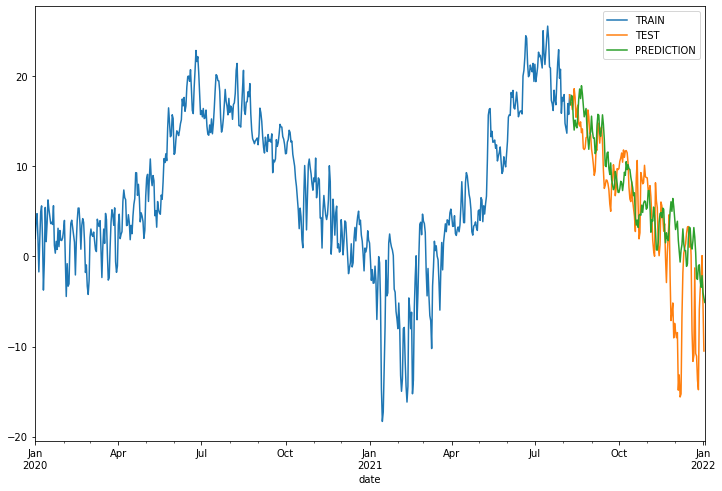

In [115]:
# plot forecasting and observations

df_train['Air temperature (degC)'].plot(legend=True,label='TRAIN')
df_test['Air temperature (degC)'].plot(legend=True,label='TEST',figsize=(12,8))
test_predictions.plot(legend=True,label='PREDICTION');

Evaluation

In [116]:
# MAE
# Disadvantage: does not tell when it is completely off

mean_absolute_error(df_test,test_predictions)

3.660096538322963

In [117]:
# MSE
# Disadvantage: units are squared

mean_squared_error(df_test,test_predictions)

28.04966471246905

In [118]:
# RMSE

np.sqrt(mean_squared_error(df_test,test_predictions))

5.296193417207216

Stationarity and differencing

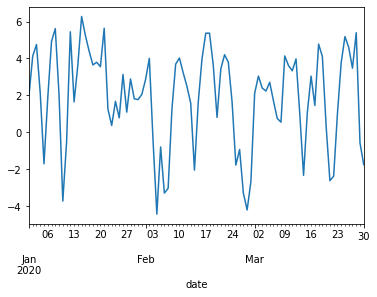

In [119]:
# extract part of the data which is stationary

df_s = df.iloc[:90]

df_s['Air temperature (degC)'].plot();

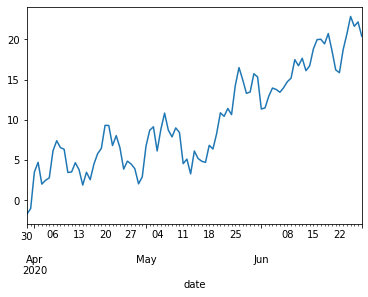

In [212]:
# non-stationary data

df_ns = df.iloc[89:180]

df_ns['Air temperature (degC)'].plot();

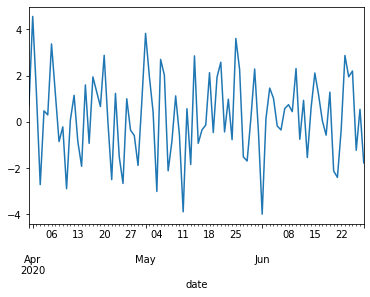

In [121]:
# create stationary data from non-stationary using first order differencing

diff(df_ns['Air temperature (degC)'],k_diff = 1).plot()

Autocorrelation plot (ACF) and Partial Autocorrelation plot (PACF)

In [122]:
import statsmodels.api as sm

from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols

In [123]:
# ignore harmless warnings

import warnings
warnings.filterwarnings("ignore")

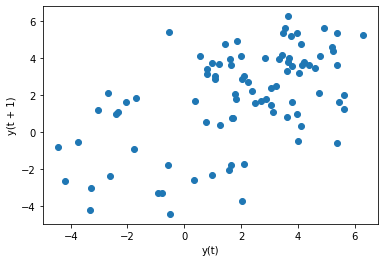

In [124]:
# non-stationary -> no much correalation

from pandas.plotting import lag_plot

lag_plot(df_s['Air temperature (degC)']);

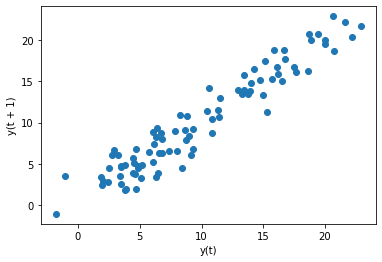

In [125]:
# stationary data -> correlation due to the e.g. seasonality

lag_plot(df_ns['Air temperature (degC)']);

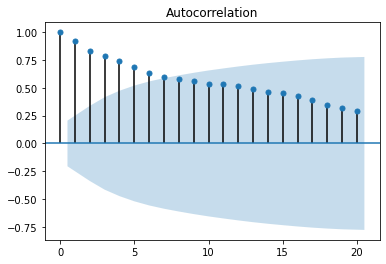

In [126]:
# ACF plots - non-stationary data

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

#AR: 

#- if ACF plot shows positive autocorrelation att lag-1, it suggests to use AR terms related to the lag
#- if negative, it is suggested to ise MA term

# below gradual drop - MA model is suggested
# identificatio of MA model is the typically better with ACF

plot_acf(df_ns);

# shaded area -> confidence interval (which is not shaded)

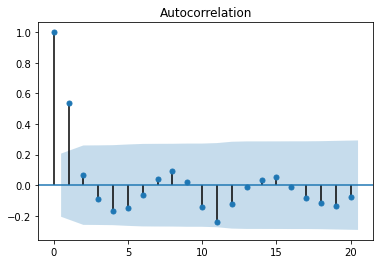

In [127]:
# ACF plots - stationary data


# below is sharp drop - AR model

plot_acf(df_s);

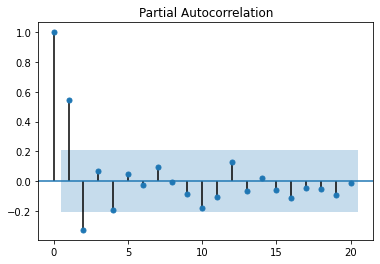

In [128]:
# PACF - stationary data
# identification of AR model is often best with PACF

plot_pacf(df_s);

In [129]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached statsmodels-0.13.2-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.8 MB)
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.9.0
    Uninstalling statsmodels-0.9.0:
      Successfully uninstalled statsmodels-0.9.0


In [130]:
# run pdmarima for stationary data

from pmdarima import auto_arima

auto_arima(df_s['Air temperature (degC)'],error_action='ignore').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   90
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -193.433
Date:                Mon, 08 Aug 2022   AIC                            392.867
Time:                        10:01:48   BIC                            400.366
Sample:                             0   HQIC                           395.891
                                 - 90                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.8943      0.417      4.540      0.000       1.077       2.712
ma.L1          0.6785      0.093      7.278      0.000       0.496       0.861
sigma2         4.2793      0.793      5.397      0.000       2.725       5.833
===================================================================================
Ljung-Box (Q):                       25.30   Jarque-Bera (JB):                 5.35
Prob(Q):                              0.97   Prob(JB):                         0.07
Heteroskedasticity (H):               0.79   Skew:                            -0.57
Prob(H) (two-sided):                  0.52   Kurtosis:                         2.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [131]:
stepwise_fit = auto_arima(df_s['Air temperature (degC)'], start_p=0, start_q=0,
                          max_p=6, max_q=3, m=12,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=468.142, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=408.845, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=413.801, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=407.187, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=406.417, Time=0.03 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=408.333, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=407.630, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=405.776, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=404.805, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=inf, Time=0.58 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=408.736, Time=0.03 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.33 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=393.475, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=392.867, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=431.505, Time

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   90
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -193.433
Date:                Mon, 08 Aug 2022   AIC                            392.867
Time:                        10:01:50   BIC                            400.366
Sample:                             0   HQIC                           395.891
                                 - 90                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.8943      0.417      4.540      0.000       1.077       2.712
ma.L1          0.6785      0.093      7.278      0.000       0.496       0.861
sigma2         4.2793      0.793      5.397      0.000       2.725       5.833
===================================================================================
Ljung-Box (Q):                       25.30   Jarque-Bera (JB):                 5.35
Prob(Q):                              0.97   Prob(JB):                         0.07
Heteroskedasticity (H):               0.79   Skew:                            -0.57
Prob(H) (two-sided):                  0.52   Kurtosis:                         2.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [132]:
# for seasonal data
# m is number of seasons. Here it is for demonstration goals only

stepwise_fit = auto_arima(df_ns['Air temperature (degC)'], start_p=0, start_q=0,
                          max_p=6, max_q=6, m=12,
                          seasonal=True,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.77 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=362.264, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=365.636, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=365.725, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=361.990, Time=0.03 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=363.682, Time=0.19 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=363.811, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=364.188, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=364.130, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.37 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 1.912 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   91
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -179.995
Date:                Mon, 08 Aug 2022   AIC                            361.990
Time:                        10:01:52   BIC                            364.489
Sample:                             0   HQIC                           362.998
                                 - 91                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         3.1963      0.527      6.061      0.000       2.163       4.230
===================================================================================
Ljung-Box (Q):                       64.06   Jarque-Bera (JB):                 0.53
Prob(Q):                              0.01   Prob(JB):                         0.77
Heteroskedasticity (H):               0.77   Skew:                            -0.09
Prob(H) (two-sided):                  0.47   Kurtosis:                         2.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

ARIMA

AutoRegressive Integrated Moving Average

ARIMA is a generalization of ARMA model
not capable to perfectly predict any TS data e.g. stock data
works good when data is directly related to the time stamp

Major components of ARIMA:
  - non seasonal (non-negative p (autoregression - regression model, d (integrated - making non-stationary to be stationary through differencing), q (moving average))

AR - p: this part indicates that evolving variable of interest is regressed on its own lagged (i.e. prior) values. **p**: number of lag observations inclided in the model

I - d: differencing tp get stationary data so that AR and MA could work. **d**: number of times that the raw observations are differenced


MA - q: indicates that regression error is a linear combination of error terms i.e. model uses dependency 
between observation and residual error - smooth out the noise. **q**: size of the moving average window i.e. order of MA

Depending on the dateset, it is common that only AR or MA are needed (or even one of them)

check stationarity: Augmented Dickey-Fuller test

**How to decide on ARIMA components/parameters (p,d,q)?**

First, make data to be stationary
different approach for differencing e.g. difference by a season
for seasonal data

Next, choice of pdq:
* ACF and PACF based on viewing decay but can be difficult to read
* Grid Search -> run different combinations (**pmdarima**: uses AIC)

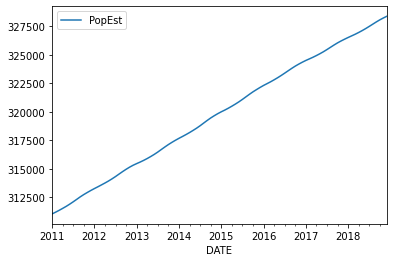

In [133]:
# AR - AutoRegression
# AR specifies that output depends linearly on previous values and
# on a stochastic term
# Load the U.S. Population dataset

df = pd.read_csv('uspopulation.csv',index_col='DATE',parse_dates=True)

df.index.freq = 'MS'

df.plot();

In [134]:
# divide into training and test sets

train = df.iloc[:84]
test = df.iloc[84:]

In [135]:
# create AR model

# Load specific forecasting tools
from statsmodels.tsa.ar_model import AR,ARResults

model_ar = AR(train['PopEst'])

In [136]:
# fit the model, order=1

AR1fit = model_ar.fit(maxlag=1)

In [137]:
# criteria

AR1fit.aic

6.410771237032229

In [138]:
# parameters

AR1fit.params

const        284.913797
L1.PopEst      0.999686
dtype: float64

In [139]:
# predict

start=len(train)
end=len(train)+len(test)-1
predictions1 = AR1fit.predict(start=start, end=end, dynamic=False).rename('AR(1) Predictions')

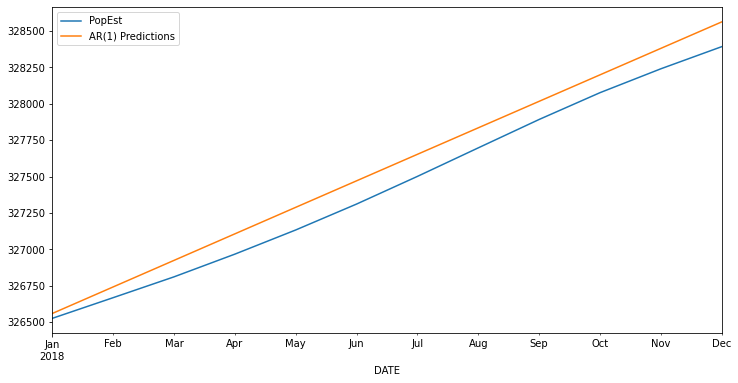

In [140]:
test['PopEst'].plot(legend=True)
predictions1.plot(legend=True,figsize=(12,6));

In [141]:
# order 2

AR2fit = model_ar.fit(maxlag=2)

predictions2 = AR2fit.predict(start=start, end=end, dynamic=False).rename('AR(2) Predictions')

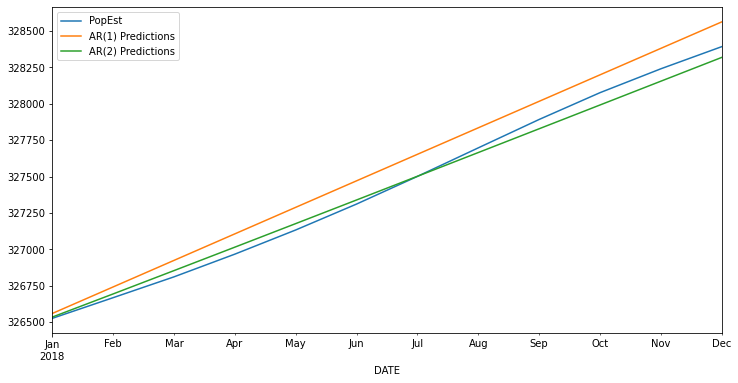

In [142]:
test['PopEst'].plot(legend=True)
predictions1.plot(legend=True,figsize=(12,6))
predictions2.plot(legend=True);

In [143]:
# define the order - ic parameter with criterion

ARfit = model_ar.fit(ic='t-stat')

predictions3 = ARfit.predict(start=start, end=end, dynamic=False).rename('AR(ic) Predictions')

# evaluate

from sklearn.metrics import mean_squared_error

preds = [predictions1, predictions2, predictions3]

labels = ['AR1','AR2','AR(ic)']

for i in range(3):
  error = mean_squared_error(test['PopEst'],preds[i])
  print(f"{labels[i]} MSE: {error}")

AR1 MSE: 17449.71423587912
AR2 MSE: 2713.2585540102214
AR(ic) MSE: 186.97053754548145


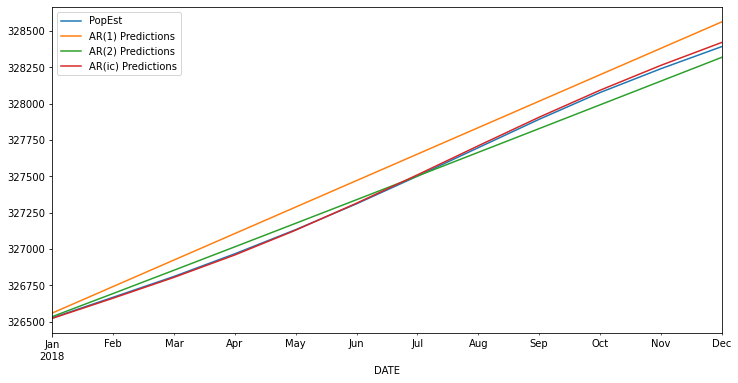

In [144]:
test['PopEst'].plot(legend=True)
predictions1.plot(legend=True,figsize=(12,6))
predictions2.plot(legend=True)
predictions3.plot(legend=True);

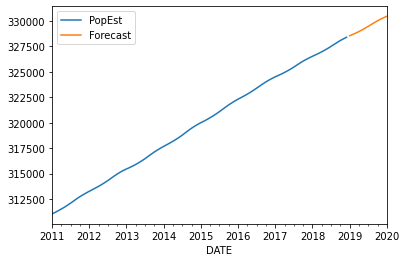

In [145]:
# forecasting

model = AR(df['PopEst'])

AR_for = model.fit()

forecast = AR_for.predict(start=len(df),end=len(df)+12).rename('Forecast')

df['PopEst'].plot(legend=True)
forecast.plot(legend=True);

Descriptive statistics

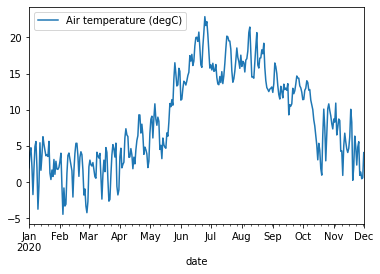

In [146]:
# seasonal df

df = pd.read_csv('espoo_2020_2022.csv',
                 parse_dates= {"date" : ["Year","m","d"]})

df.dropna(axis=0,inplace=True)

df = df.groupby(['date']).mean()

df.index.freq = "D"

df_2020 = df['2020-01-01':'2020-12-01']

df_2020.plot();

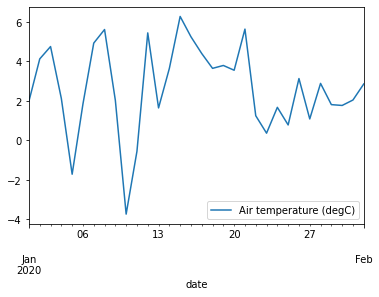

In [147]:
# non-seasonal data

df_jan2020 = df['2020-01-01':'2020-02-01']

df_jan2020.plot();

In [148]:
# import libraries

from statsmodels.tsa.stattools import adfuller,kpss,coint,bds,q_stat,grangercausalitytests,levinson_durbin
from statsmodels.tsa.stattools import ccovf,ccf,periodogram
from statsmodels.tools.eval_measures import mse, rmse, meanabs

In [149]:
# function for adfuller test

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [150]:
adf_test(df_2020['Air temperature (degC)'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -1.716998
p-value                   0.422377
# lags used               5.000000
# observations          330.000000
critical value (1%)      -3.450322
critical value (5%)      -2.870338
critical value (10%)     -2.571458
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [151]:
adf_test(df_jan2020['Air temperature (degC)'])

Augmented Dickey-Fuller Test: 
ADF test statistic      -4.110494
p-value                  0.000931
# lags used             10.000000
# observations          21.000000
critical value (1%)     -3.788386
critical value (5%)     -3.013098
critical value (10%)    -2.646397
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


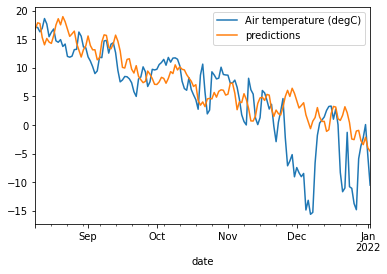

In [152]:
# causuality (test set from the beginning and it's predictions will be used)

df_caus.dropna(axis=0,inplace=True)

df_caus[['Air temperature (degC)','predictions']].plot();

In [153]:
# test -> check if p < 0.05 and determine lags

grangercausalitytests(df_caus[['Air temperature (degC)','predictions']],maxlag=10);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.9450  , p=0.0160  , df_denom=143, df_num=1
ssr based chi2 test:   chi2=6.0698  , p=0.0138  , df=1
likelihood ratio test: chi2=5.9470  , p=0.0147  , df=1
parameter F test:         F=5.9450  , p=0.0160  , df_denom=143, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.1096  , p=0.0184  , df_denom=140, df_num=2
ssr based chi2 test:   chi2=8.5127  , p=0.0142  , df=2
likelihood ratio test: chi2=8.2722  , p=0.0160  , df=2
parameter F test:         F=4.1096  , p=0.0184  , df_denom=140, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.3662  , p=0.0736  , df_denom=137, df_num=3
ssr based chi2 test:   chi2=7.4613  , p=0.0586  , df=3
likelihood ratio test: chi2=7.2744  , p=0.0636  , df=3
parameter F test:         F=2.3662  , p=0.0736  , df_denom=137, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.4721  , p=0.2142  

In [154]:
# evaluation

print(rmse(df_caus['Air temperature (degC)'],df_caus['predictions']))

print(meanabs(df_caus['Air temperature (degC)'],df_caus['predictions']))


5.436715188526791
3.8822463310826074


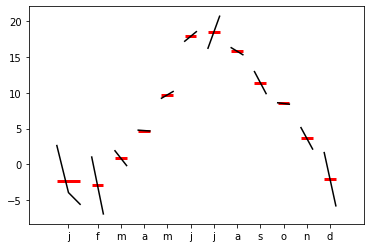

In [155]:
# make monthly plot - ranges and average

from statsmodels.graphics.tsaplots import month_plot,quarter_plot

df = pd.read_csv('espoo_2020_2022.csv',
                 parse_dates= {"date" : ["Year","m"]})

df.dropna(axis=0,inplace=True)

df = df.groupby(['date']).mean()

df.index.freq = "MS"

month_plot(df['Air temperature (degC)']);

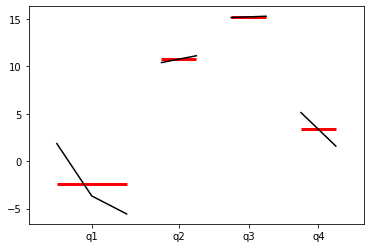

In [156]:
# quarter plot

dfq = df['Air temperature (degC)'].resample(rule='Q').mean()

quarter_plot(dfq);

Create ARMA (PQ) and ARIMA (PDQ) models

In [157]:
# Load specific forecasting tools
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima # for determining ARIMA orders

ARMA

In [158]:
# stationary data only can be used

df1 = pd.read_csv('DailyTotalFemaleBirths.csv',index_col='Date',parse_dates=True)
df1.index.freq = 'D'
df1 = df1[:120]  # we only want the first four months

In [159]:
# confirm stationarity

adf_test(df1['Births'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -9.855384e+00
p-value                 4.373545e-17
# lags used             0.000000e+00
# observations          1.190000e+02
critical value (1%)    -3.486535e+00
critical value (5%)    -2.886151e+00
critical value (10%)   -2.579896e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [160]:
# determina p,q orders

auto_arima(df1['Births'],seasonal=False).summary()

# note that here sarimax is suggsted but for demonstration aims we go with ARMA(2,2)

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:                        SARIMAX   Log Likelihood                -409.745
Date:                Mon, 08 Aug 2022   AIC                            823.489
Time:                        10:01:58   BIC                            829.064
Sample:                             0   HQIC                           825.753
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     39.7833      0.687     57.896      0.000      38.437      41.130
sigma2        54.1197      8.319      6.506      0.000      37.815      70.424
===================================================================================
Ljung-Box (Q):                       44.41   Jarque-Bera (JB):                 2.69
Prob(Q):                              0.29   Prob(JB):                         0.26
Heteroskedasticity (H):               0.80   Skew:                             0.26
Prob(H) (two-sided):                  0.48   Kurtosis:                         2.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [161]:
# split into train and test sets

train = df1.iloc[:90]
test = df1.iloc[90:]

In [162]:
# fit the model

model = ARMA(df1['Births'],order=(2,2))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Births   No. Observations:                  120
Model:                     ARMA(2, 2)   Log Likelihood                -405.370
Method:                       css-mle   S.D. of innovations              6.991
Date:                Mon, 08 Aug 2022   AIC                            822.741
Time:                        10:01:59   BIC                            839.466
Sample:                    01-01-1959   HQIC                           829.533
                         - 04-30-1959                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           39.8162      0.108    368.850      0.000      39.605      40.028
ar.L1.Births     1.8569      0.081     22.942      0.000       1.698       2.016
ar.L2.Births    -0.8814      0.073    -12.035      0.000      -1.025      -0.738
ma.L1.Births    -1.8634      0.109    -17.130      0.000      -2.077      -1.650
ma.L2.Births     0.8634      0.108      8.022      0.000       0.652       1.074
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0533           -0.1582j            1.0651           -0.0237
AR.2            1.0533           +0.1582j            1.0651            0.0237
MA.1            1.0000           +0.0000j            1.0000            0.0000
MA.2            1.1582           +0.0000j            1.1582            0.0000
-----------------------------------------------------------------------------
"""

In [163]:
# make predictions

start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end).rename('ARMA(2,2) Predictions')

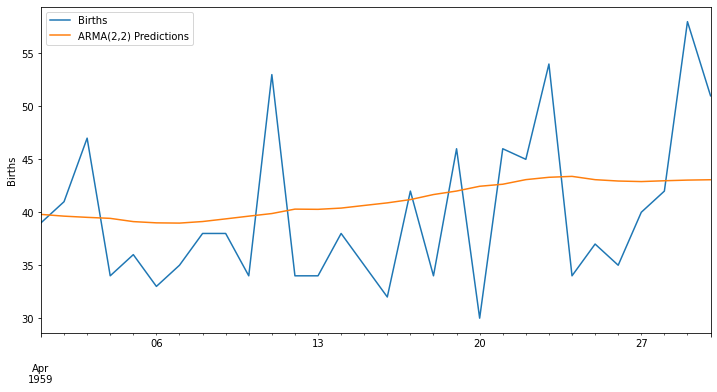

In [164]:
title = 'Daily Total Female Births'
ylabel='Births'
xlabel='' # we don't really need a label here

ax = test['Births'].plot(legend=True,figsize=(12,6))
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [165]:
# check mean values

test.mean()

Births    39.833333
dtype: float64

In [166]:
predictions.mean()

41.12605470511519

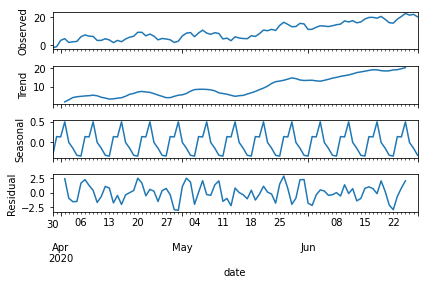

In [214]:
# seasonal data
# ETS

from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df_ns['Air temperature (degC)'], model='additive')  # model='add' also works
result.plot();

In [215]:
# pmdarima

auto_arima(df_ns['Air temperature (degC)'],seasonal=False).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   91
Model:               SARIMAX(2, 1, 3)   Log Likelihood                -172.142
Date:                Mon, 08 Aug 2022   AIC                            358.285
Time:                        11:23:38   BIC                            375.783
Sample:                             0   HQIC                           365.341
                                 - 91                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4615      0.322      1.432      0.152      -0.170       1.093
ar.L1         -0.0863      0.069     -1.256      0.209      -0.221       0.048
ar.L2         -0.8873      0.068    -13.094      0.000      -1.020      -0.755
ma.L1          0.0899      0.131      0.688      0.491      -0.166       0.346
ma.L2          0.8705      0.097      8.975      0.000       0.680       1.061
ma.L3         -0.2178      0.129     -1.694      0.090      -0.470       0.034
sigma2         2.6167      0.526      4.979      0.000       1.587       3.647
===================================================================================
Ljung-Box (Q):                       37.82   Jarque-Bera (JB):                 2.32
Prob(Q):                              0.57   Prob(JB):                         0.31
Heteroskedasticity (H):               0.62   Skew:                            -0.27
Prob(H) (two-sided):                  0.20   Kurtosis:                         2.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [216]:
# augmented DF test in the first difference

df_ns['d1'] = diff(df_ns['Air temperature (degC)'],k_diff=1)

adf_test(df_ns['d1'])

# we see that d should be 1 since p<0.05

Augmented Dickey-Fuller Test: 
ADF test statistic      -5.484490
p-value                  0.000002
# lags used              9.000000
# observations          80.000000
critical value (1%)     -3.514869
critical value (5%)     -2.898409
critical value (10%)    -2.586439
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


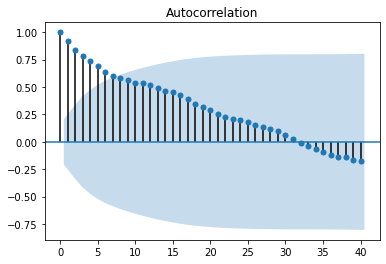

In [217]:
# ACF and PACF
# MA should 0 or 1 -> gradual decrease and shart cut in PACF

plot_acf(df_ns['Air temperature (degC)'],lags=40);

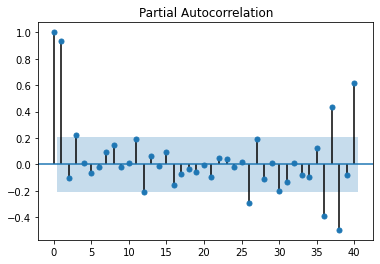

In [218]:
plot_pacf(df_ns['Air temperature (degC)'],lags=40);

# sharp cutoff -> add AR to the model (deep cutoff at 1, p=1)

In [220]:
stepwise_fit = auto_arima(df_ns['Air temperature (degC)'], start_p=0, start_q=0,
                          max_p=6, max_q=6, m=12,
                          seasonal=False,
                          trace=True)
                          
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=362.264, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=364.188, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=364.130, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=361.990, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.55 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.818 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   91
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -179.995
Date:                Mon, 08 Aug 2022   AIC                            361.990
Time:                        11:23:51   BIC                            364.489
Sample:                             0   HQIC                           362.998
                                 - 91                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         3.1963      0.527      6.061      0.000       2.163       4.230
===================================================================================
Ljung-Box (Q):                       64.06   Jarque-Bera (JB):                 0.53
Prob(Q):                              0.01   Prob(JB):                         0.77
Heteroskedasticity (H):               0.77   Skew:                            -0.09
Prob(H) (two-sided):                  0.47   Kurtosis:                         2.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [222]:
# split into train and test sets

train = df_ns.iloc[:61]
test = df_ns.iloc[61:]

In [224]:
# fit the model

model = ARIMA(train['Air temperature (degC)'],order=(1,1,0))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                ARIMA Model Results                                 
====================================================================================
Dep. Variable:     D.Air temperature (degC)   No. Observations:                   60
Model:                       ARIMA(1, 1, 0)   Log Likelihood                -122.532
Method:                             css-mle   S.D. of innovations              1.865
Date:                      Mon, 08 Aug 2022   AIC                            251.063
Time:                              11:24:34   BIC                            257.346
Sample:                          03-31-2020   HQIC                           253.521
                               - 05-29-2020                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                              0.2536      0.242      1.050      0.298      -0.220       0.727
ar.L1.D.Air temperature (degC)     0.0033      0.128      0.025      0.980      -0.248       0.254
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          307.4040           +0.0000j          307.4040            0.0000
-----------------------------------------------------------------------------
"""

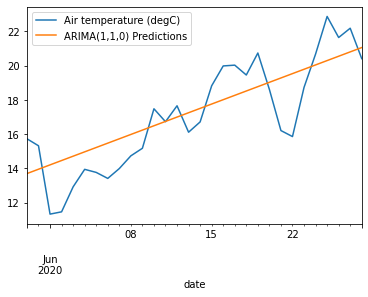

In [225]:
# predictions

start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(1,1,0) Predictions')

test['Air temperature (degC)'].plot(legend=True)
predictions.plot(legend=True).plot();

# seasonal effect is not taken into account

In [226]:
error = rmse(test['Air temperature (degC)'],predictions)
error

1.7360016237157507

In [227]:
# forecast

model = ARIMA(df_ns['Air temperature (degC)'],order=(1,1,0))

results = model.fit()

forecast = results.predict(start=len(df_ns),end = len(df_ns)+30,typ='levels').rename('ARIMA (1,1,0) FORECAST')

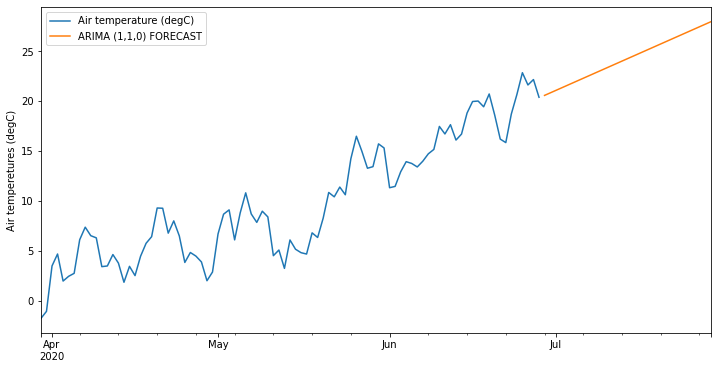

In [228]:
# Plot predictions against known values
ylabel='Air temperetures (degC)'
xlabel='' # we don't really need a label here

ax = df_ns['Air temperature (degC)'].plot(legend=True,figsize=(12,6))
forecast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

Seasonal ARIMA => SARIMA

P, D, Q -> seasonal regression, differencing, and MA

m -> number of data points in each seasonal cycle

In statsmodels -> SARIMAX

In [229]:
# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

In [238]:
# load dataset

df = pd.read_csv('co2_mm_mlo.csv')

df['date']=pd.to_datetime(dict(year=df['year'], month=df['month'], day=1))

df.set_index('date',inplace=True)
df.index.freq = 'MS'

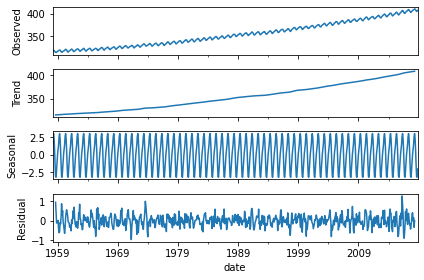

In [239]:
# check seasonality

result = seasonal_decompose(df['interpolated'], model='add')
result.plot();

In [240]:
# For SARIMA Orders we set seasonal=True and pass in an m value
auto_arima(df['interpolated'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  729
Model:             SARIMAX(0, 1, 3)x(1, 0, 1, 12)   Log Likelihood                -205.691
Date:                            Mon, 08 Aug 2022   AIC                            423.383
Time:                                    11:58:18   BIC                            450.925
Sample:                                         0   HQIC                           434.010
                                            - 729                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3564      0.035    -10.199      0.000      -0.425      -0.288
ma.L2         -0.0221      0.022     -1.006      0.314      -0.065       0.021
ma.L3         -0.0859      0.028     -3.037      0.002      -0.141      -0.030
ar.S.L12       0.9996      0.000   2925.468      0.000       0.999       1.000
ma.S.L12      -0.8661      0.021    -40.550      0.000      -0.908      -0.824
sigma2         0.0955      0.005     20.390      0.000       0.086       0.105
===================================================================================
Ljung-Box (Q):                       43.66   Jarque-Bera (JB):                 4.02
Prob(Q):                              0.32   Prob(JB):                         0.13
Heteroskedasticity (H):               1.13   Skew:                             0.00
Prob(H) (two-sided):                  0.33   Kurtosis:                         3.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [241]:
# split into train and test sets

train = df.iloc[:717]
test = df.iloc[717:]

In [242]:
# fit the model 

model = SARIMAX(train['interpolated'],order=(0,1,3),seasonal_order=(1,0,1,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                       interpolated   No. Observations:                  717
Model:             SARIMAX(0, 1, 3)x(1, 0, 1, 12)   Log Likelihood                -201.188
Date:                            Mon, 08 Aug 2022   AIC                            414.377
Time:                                    11:59:21   BIC                            441.819
Sample:                                03-01-1958   HQIC                           424.973
                                     - 11-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3540      0.036     -9.699      0.000      -0.426      -0.282
ma.L2         -0.0246      0.037     -0.672      0.501      -0.096       0.047
ma.L3         -0.0871      0.029     -2.991      0.003      -0.144      -0.030
ar.S.L12       0.9996      0.000   3076.951      0.000       0.999       1.000
ma.S.L12      -0.8661      0.023    -38.333      0.000      -0.910      -0.822
sigma2         0.0950      0.005     20.305      0.000       0.086       0.104
===================================================================================
Ljung-Box (Q):                       43.94   Jarque-Bera (JB):                 4.35
Prob(Q):                              0.31   Prob(JB):                         0.11
Heteroskedasticity (H):               1.15   Skew:                             0.02
Prob(H) (two-sided):                  0.28   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [243]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(0,1,3)(1,0,1,12) Predictions')

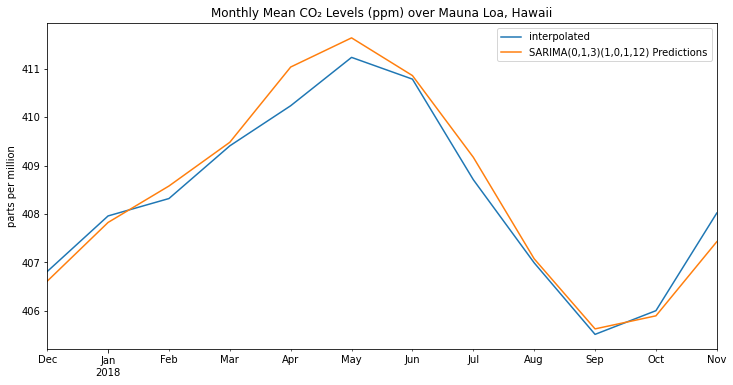

In [244]:
# Plot predictions against known values
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel=''

ax = test['interpolated'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [246]:
error = rmse(test['interpolated'], predictions)
print(f'SARIMA(0,1,3)(1,0,1,12) RMSE Error: {error:11.10}')

SARIMA(0,1,3)(1,0,1,12) RMSE Error: 0.3580037591


In [247]:
error = mean_squared_error(test['interpolated'], predictions)
print(f'SARIMA(0,1,3)(1,0,1,12) MSE Error: {error:11.10}')

SARIMA(0,1,3)(1,0,1,12) MSE Error: 0.1281666915


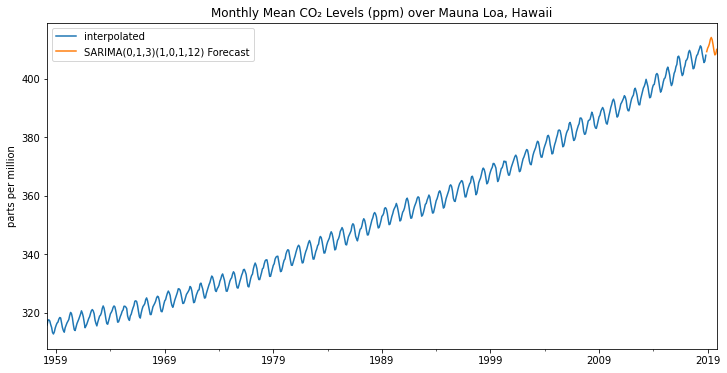

In [250]:
# forecast

model = SARIMAX(df['interpolated'],order=(0,1,3),seasonal_order=(1,0,1,12))
results = model.fit()
forecast = results.predict(len(df),len(df)+11,typ='levels').rename('SARIMA(0,1,3)(1,0,1,12) Forecast')

title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel=''

ax = df['interpolated'].plot(legend=True,figsize=(12,6),title=title)
forecast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);